In [1]:
#MIT license from @marcopassini 
#Basd on: https://github.com/marcoppasini/MelGAN-VC/blob/master/MelGAN_VC.ipynb
# This file is only intended as a reproduction for https://github.com/pytorch/pytorch/issues/16417

!nvidia-smi

Sun Feb  7 14:20:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:09:00.0  On |                  N/A |
| 27%   54C    P0    57W / 180W |    663MiB /  8111MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5.0

In [3]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [4]:
#Hyperparameters

hop=192               #hop size (window size = 6*hop)
sr=16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [5]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
  return np.array(np.squeeze(wv))

In [6]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object)
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*16000):
  x, sr = librosa.load(path,sr=16000)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

In [7]:
!nvidia-smi

Sun Feb  7 14:21:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:09:00.0  On |                  N/A |
| 27%   54C    P2    63W / 180W |   1245MiB /  8111MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [9]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [10]:
!nvidia-smi

Sun Feb  7 14:21:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:09:00.0  On |                  N/A |
| 27%   55C    P2    62W / 180W |   1247MiB /  8111MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  ab = gen(a, training=False)
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='./'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [12]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [13]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [14]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  aa,aa2,aa3 = extract_image(a) 
  bb,bb2,bb3 = extract_image(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    #translating A to B
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
    fid = gen(bb, training=True) 
    fid2 = gen(bb2, training=True)
    fid3 = gen(bb3, training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)
    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  with tf.GradientTape() as tape_disc:

    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [15]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  c = 0
  g = 0
  
  for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
                      

In [16]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=True, path='./')

Built networks


In [17]:
!nvidia-smi

Sun Feb  7 14:21:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:09:00.0  On |                  N/A |
| 27%   55C    P2    62W / 180W |   7710MiB /  8111MiB |     52%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
def get_model_memory_usage(batch_size, model):
    #Thanks to @ZFTurbo on https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model/45242364
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

print('Memory usage in GB for each model:')
print(get_model_memory_usage(1, gen))
print(get_model_memory_usage(1, critic))
print(get_model_memory_usage(1, siam))

Memory usage in GB for each model:
0.011
0.017
0.005


In [19]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

#train(5000, batch_size=bs, lr=0.0002, n_save=1, gupt=3)

In [20]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

In [21]:
!nvidia-smi

Sun Feb  7 14:21:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:09:00.0  On |                  N/A |
| 27%   55C    P2    62W / 180W |   7712MiB /  8111MiB |     52%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(983342,)


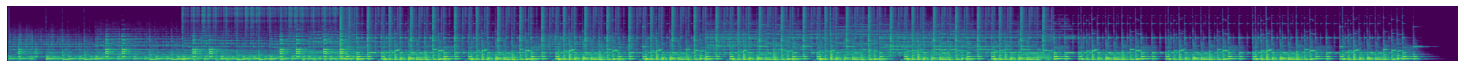

(214, 192, 24, 1)
Generating...
  0%|          | 0/2000 [00:00<?, ?it/s]Assembling and Converting...



RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.92 GiB total capacity; 79.29 MiB already allocated; 41.69 MiB free; 118.00 MiB reserved in total by PyTorch)

In [22]:
#Wav to wav conversion

wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME1', path='./')           #Convert and save wav

In [ ]:
import pydot
tf.keras.utils.plot_model(gen, show_shapes=True, dpi=64)


In [ ]:
tf.keras.utils.plot_model(critic, show_shapes=True, dpi=64)


In [ ]:
tf.keras.utils.plot_model(siam, show_shapes=True, dpi=64)